Author Tenure
===

Notebook for analysis of author tenure.

In [36]:
%matplotlib inline

from pathlib import Path
import os
import subprocess

import pandas as pd
import numpy as np

from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

from datetime import datetime

In [3]:
from pomegranate import *

In [28]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
figures_dir = os.path.join(git_root_dir, 'figures')
figures_dir

'/panfs/roc/groups/3/srivbane/levon003/repos/sna-social-support/figures'

In [6]:
# read in the interactions dataframe
metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
author_to_site = os.path.join(metadata_dir, "interaction_metadata.h5")
ints_df = pd.read_hdf(author_to_site)
len(ints_df)

28388948

In [7]:
# as a quick fix for invalid dates in journals, when created_at is 0 we use the updated_at instead
invalid_created_at = ints_df.created_at <= 0
print(np.sum(invalid_created_at))
ints_df.loc[invalid_created_at, 'created_at'] = ints_df.loc[invalid_created_at, 'updated_at']
print(np.sum(ints_df.created_at <= 0))

44
0


In [39]:
author_end_date = datetime.fromisoformat('2016-06-01')
author_end_timestamp = int(interaction_end_date.timestamp() * 1000)

In [40]:
auths = ints_df[(ints_df.int_type == 'journal')&(ints_df.created_at <= author_end_timestamp)].groupby('user_id').agg({
    'created_at': lambda created_at: (np.min(created_at), np.max(created_at)),
    'site_id': len
})

In [41]:
first_and_last = np.array(auths.created_at.tolist())
auths['first_update'] = first_and_last[:,0]
auths['last_update'] = first_and_last[:,1]

In [42]:
auths = auths.drop(columns='created_at').rename(columns={'site_id': 'num_journals'})

In [ ]:
# deprecated, I don't remember what this file contained
auths = pd.read_csv("/home/levon003/repos/sna-social-support/network_data/dynamic_auth.csv", 
                    header=None, names=['userId', 'num_journals', 'first_update', 'last_update'])
len(auths)

In [43]:
auths.head()

,num_journals,first_update,last_update
user_id,,,
0,1101455,1073968020000,1372634100000
1,187,1103856900000,1261008420000
2,29,1117053060000,1180149600000
3,1,1117605718000,1117605718000
4,2,1117605820000,1147748940000


In [57]:
len(set(auths.index))

572309

In [44]:
auths['tenure'] = auths.last_update - auths.first_update

In [69]:
# 28.3% of authors have only a single journal update
len(auths[auths.tenure == 0].tenure), len(auths[auths.tenure == 0].tenure) / len(auths)

(161799, 0.28271266046838334)

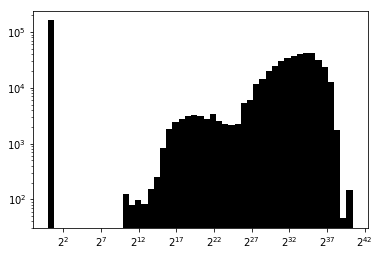

In [46]:
x = auths.tenure + 1
num_bins=50
base = 2
logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
plt.hist(x, bins=logbins, color='black', log=True)
plt.xscale('log', nonposx='clip', basex=base)
plt.show()

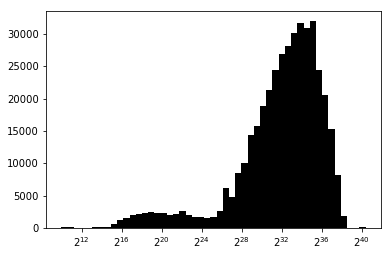

In [47]:
x = auths[auths.tenure > 0].tenure
num_bins=50
base = 2
logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
plt.hist(x, bins=logbins, color='black')
plt.xscale('log', nonposx='clip', basex=base)
plt.show()

In [48]:
x_train = x.values.reshape(-1, 1)
model = GeneralMixtureModel.from_samples([LogNormalDistribution, LogNormalDistribution], 
                                         n_components=2, X=x_train,
                                         stop_threshold=0.01)
model

{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "LogNormalDistribution",
            "parameters" : [
                15.397910484279024,
                3.010386606438301
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "LogNormalDistribution",
            "parameters" : [
                22.84676852272968,
                1.8509278150215311
            ],
            "frozen" : false
        }
    ],
    "weights" : [
        0.10965487411956669,
        0.8903451258804334
    ]
}

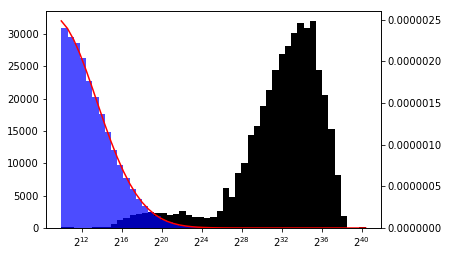

In [49]:
num_bins=50
base = 2
logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
plt.hist(x, bins=logbins, color='black')
plt.xscale('log', nonposx='clip', basex=base)
ax2 = plt.gca().twinx()
plt.hist(model.distributions[0].sample(1000000), color='blue', bins=logbins, alpha=0.7, density=True)
#plt.hist(model.distributions[1].sample(10000), color='red', bins=logbins, alpha=0.7, density=True)
# plot the probability density of learned lognormal distributions
ax2.plot(logbins, [np.exp(model.distributions[0].log_probability(bin_edge)) for bin_edge in logbins], color='red')
#ax2.plot(logbins, [np.exp(model.distributions[1].log_probability(bin_edge)) for bin_edge in logbins], color='blue')
plt.show()

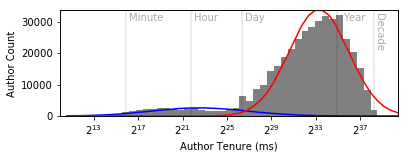

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(5.47807, 2))

num_bins=50
base = 2
logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
plt.hist(x, bins=logbins, color='gray')
plt.xscale('log', nonposx='clip', basex=base)
ax = plt.gca()

plt.xlabel("Author Tenure (ms)")
plt.ylabel("Author Count")
#plt.title("Distribution of CaringBridge author tenure")

# add semantically interpretable time moments
ax.axvline(1000 * 60, color='black', alpha=0.1)
ax.axvline(1000 * 60 * 60, color='black', alpha=0.1)
ax.axvline(1000 * 60 * 60 * 24, color='black', alpha=0.1)
ax.axvline(1000 * 60 * 60 * 24 * 365, color='black', alpha=0.1)
ax.axvline(1000 * 60 * 60 * 24 * 365 * 10, color='black', alpha=0.1)
text_y = ax.transData.inverted().transform((0, ax.transAxes.transform((0, 0.90))[1]))[1]  # https://matplotlib.org/users/transforms_tutorial.html
ax.text(1000 * 60 * 1.2, text_y, 'Minute', color='darkgray')
ax.text(1000 * 60 * 60 * 1.2, text_y, 'Hour', color='darkgray')
ax.text(1000 * 60 * 60 * 24 * 1.2, text_y, 'Day', color='darkgray')
ax.text(1000 * 60 * 60 * 24 * 365 * 1.5, text_y, 'Year', color='darkgray')
ax.text(1000 * 60 * 60 * 24 * 365 * 10, text_y, 'Decade', color='darkgray', rotation=270)

ax2 = ax.twinx()
#plt.hist(model.distributions[0].sample(int(1000000 * np.exp(model.weights[0]))), color='blue', bins=logbins, alpha=0.7)
vals = model.distributions[0].sample(int(1000000 * np.exp(model.weights[0])))
hist, _ = np.histogram(vals, bins=logbins, density=False)
ax2.plot(logbins[1:], hist, color='blue')

#plt.hist(model.distributions[1].sample(int(1000000 * np.exp(model.weights[1]))), color='red', bins=logbins, alpha=0.7)
vals = model.distributions[1].sample(int(1000000 * np.exp(model.weights[1])))
hist, _ = np.histogram(vals, bins=logbins, density=False)
ax2.plot(logbins[1:], hist, color='red')
ax2.hist([0], bins=logbins) # this is a cheaty way to force the right yaxis to align 0 along the baseline

# turn off yticks
ax2.tick_params(axis='y', right=False, labelright=False)

plt.tight_layout(pad=0)
plt.margins(0,0)
plt.savefig(os.path.join(figures_dir, 'author_tenure_distribution.pdf'), dpi=180, pad_inches=0)

plt.show()

In [67]:
# the mean author tenure is about 1 year
np.mean(x) / 1000 / 60 / 60 / 24 # days

310.7210081699694

In [52]:
# the median author tenure is 82 days
np.quantile(x, 0.5) / 1000 / 60 / 60 / 24 # days

82.95635995370371

In [53]:
# 99% of author tenures are less than 7 years
np.quantile(x, 0.99) / 1000 / 60 / 60 / 24 / 365 # years

7.119288317795512

In [54]:
# 1% of author tenures are less than 2 minutes
np.quantile(x, 0.01) / 1000 / 60 # minutes

1.8333333333333333

In [55]:
# The mean of the estimated lognormal distribution is 95 days
np.exp(model.distributions[0].parameters[0]) / 1000 / 60 / 60 / 24 # days

0.05632663588022507

In [404]:
m1, s1 = model.distributions[0].parameters
m1, s1 = np.exp(m1), np.exp(s1)
m2, s2 = model.distributions[1].parameters
m2, s2 = np.exp(m2), np.exp(s2)
w1, w2 = model.weights
w1, w2 = np.exp(w1), np.exp(w2)
w1, w2

(0.8910564950736571, 0.1089435049263429)

In [377]:
assert np.isclose(m1, lognorm.ppf(0.5,s1,0,m1))
assert np.isclose(m2, lognorm.ppf(0.5,s2,0,m2))

In [356]:
lognorm.cdf(1000 * 60 * 60 * 24,s1,0,m1), lognorm.cdf(1000 * 60 * 60 * 24,s2,0,m2)

(0.23725577582661211, 0.5582972430344108)

In [409]:
lognorm.interval(0.9,s1,0,m1), lognorm.interval(0.9,s2,0,m2)

((231016.01030180894, 293554672307130.25),
 (2.7056130078741803e-08, 7.987181425580831e+20))

In [414]:
231016 / 1000 / 60, 293554672307130 / 1000 / 60 / 60 / 24 / 365 / 10

(3.8502666666666667, 930.8557594721273)

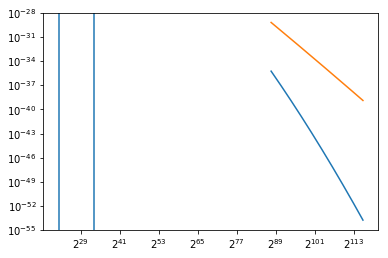

In [388]:
start = 1000 * 60 * 60 * 24 # day
end = 1000 * 60 * 60 * 24 * 365 # 20 days
times = np.logspace(np.log2(start), np.log2(end), num=10000)
matching_time = 0
t1s = []
t2s = []
for i, time in enumerate(times):
    t1 = lognorm.pdf(time,s1,0,m1)
    t2 = lognorm.pdf(time,s2,0,m2)
    t1s.append(t1)
    t2s.append(t2)
    #if t1 >= t2:
    #    print(i, time, t1 - t2)
    #    matching_time = time
    #    break
plt.plot(times[:len(t1s)],t1s)
plt.plot(times[:len(t1s)],t2s)
ax = plt.gca()
ax.axvline(m1)
ax.axvline(m2)
ax.set_xscale("log", nonposx='clip', basex=2)
ax.set_yscale("log", nonposy='clip')
plt.show()

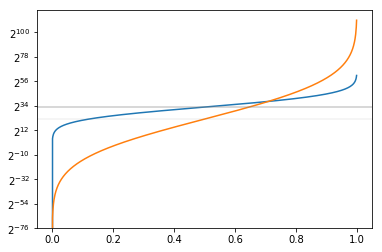

In [417]:
quantiles = np.linspace(0, 1, num=1000)
t1s = []
t2s = []
for i, q in enumerate(quantiles):
    t1 = lognorm.ppf(q,s1,0,m1)
    t2 = lognorm.ppf(q,s2,0,m2)
    t1s.append(t1)
    t2s.append(t2)
plt.plot(quantiles,t1s)
plt.plot(quantiles,t2s)
ax = plt.gca()
ax.axhline(m1, color='gray', alpha=0.4)
ax.axhline(m2, color='gray', alpha=0.1)
ax.set_yscale("log", nonposy='clip', basey=2)
plt.show()

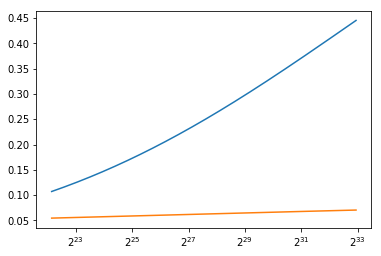

In [406]:
assert m2 < m1
times = np.linspace(m2, m1, num=10000)
t1s = []
t2s = []
for i, t in enumerate(times):
    t1 = lognorm.cdf(t,s1,0,m1)
    t2 = lognorm.cdf(t,s2,0,m2)
    t1 = t1 * w1
    t2 = t2 * w2
    t1s.append(t1)
    t2s.append(t2)
plt.plot(times,t1s)
plt.plot(times,t2s)
ax = plt.gca()
#ax.axvline(m1)
#ax.axvline(m2)
ax.set_xscale("log", nonposx='clip', basex=2)
#ax.set_yscale("log", nonposy='clip', basey=2)
plt.show()

### Num Journals

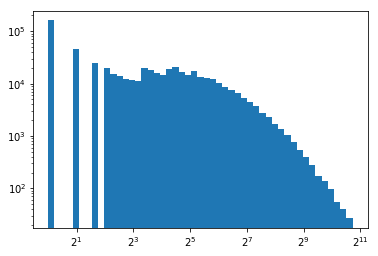

In [213]:
x = auths.num_journals
num_bins=50
base = 2
logbins = np.logspace(np.log2(min(x)), np.log2(np.quantile(x, 0.9999)), num=num_bins, base=base, endpoint=True)
plt.hist(x, log=True, bins=logbins)
plt.xscale('log', nonposx='clip', basex=base)
plt.show()

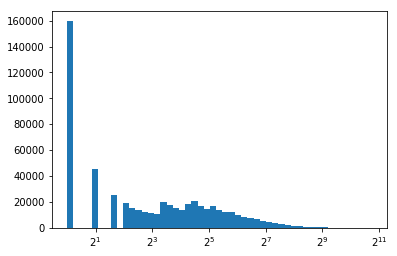

In [281]:
x = auths.num_journals
num_bins=50
base = 2
logbins = np.logspace(np.log2(min(x)), np.log2(np.quantile(x, 0.9999)), num=num_bins, base=base, endpoint=True)
plt.hist(x, log=False, bins=logbins)
plt.xscale('log', nonposx='clip', basex=base)
plt.show()

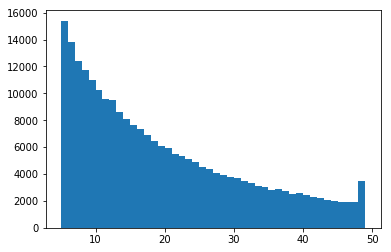

In [286]:
# stairstep pattern above is illusory
x = auths.num_journals
plt.hist(x, log=False, bins=range(5, 50))
plt.show()

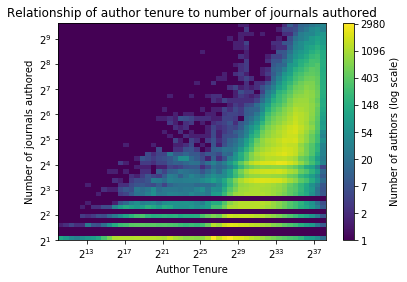

In [280]:
subset = auths[(auths.num_journals > 1)&(auths.tenure > 0)]
x = subset.tenure.values.tolist()
y = subset.num_journals.values.tolist()
num_bins=50
base = 2
x_logbins = np.logspace(np.log2(min(x)), np.log2(np.quantile(x, 0.999)), num=num_bins, base=base, endpoint=True)
y_logbins = np.logspace(np.log2(min(y)), np.log2(np.quantile(y, 0.999)), num=num_bins, base=base, endpoint=True)
logbins = [x_logbins, y_logbins]

bin_values, _, __ = np.histogram2d(x, y, bins=logbins)

X, Y = np.meshgrid(x_logbins,y_logbins)
fig, ax = plt.subplots(ncols=1)
mesh = ax.pcolormesh(X, Y, np.log(bin_values.T + 1))

highest_count_log = np.log(np.max(bin_values + 1))
cbar = plt.colorbar(mesh, ticks=[val for val in range(0, int(highest_count_log) + 1)])
cbar.ax.set_yticklabels([f"{int(np.exp(val))}" for val in range(0, int(highest_count_log) + 1)])
cbar.ax.set_ylabel("Number of authors (log scale)")

plt.xscale('log', nonposx='clip', basex=base)
plt.yscale('log', nonposy='clip', basey=base)
plt.xlabel("Author Tenure")
plt.ylabel("Number of journals authored")
plt.title("Relationship of author tenure to number of journals authored")
plt.show()

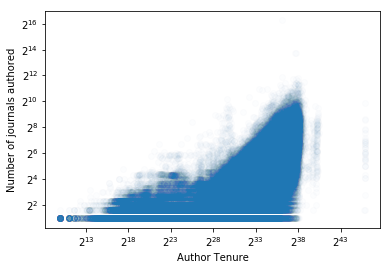

In [278]:
plt.scatter(x, y, alpha=0.01)
plt.xscale('log', nonposx='clip', basex=base)
plt.yscale('log', nonposy='clip', basey=base)
plt.xlabel("Author Tenure")
plt.ylabel("Number of journals authored")
plt.show()